In [1]:
# https://gist.github.com/mbednarski/da08eb297304f7a66a3840e857e060a0
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

In [13]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'queen is a woman',
    'king is a man',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',   
]

In [14]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

In [15]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [16]:

window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # Each word is treated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

In [17]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [18]:
embedding_dims = 10
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 10001
learning_rate = 0.005

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

Loss at epo 0: 4.916944374806351
Loss at epo 10: 2.8667606353759765
Loss at epo 20: 2.2556522882646983
Loss at epo 30: 2.0090840491983624
Loss at epo 40: 1.8818956865204706
Loss at epo 50: 1.8005154934194354
Loss at epo 60: 1.742358934879303
Loss at epo 70: 1.6990600718392266
Loss at epo 80: 1.6672926425933838
Loss at epo 90: 1.645021037922965
Loss at epo 100: 1.6296965837478639
Loss at epo 110: 1.6189842502276102
Loss at epo 120: 1.6112871448198953
Loss at epo 130: 1.6055732051531473
Loss at epo 140: 1.6011907584137386
Loss at epo 150: 1.5977321730719671
Loss at epo 160: 1.5949378761980268
Loss at epo 170: 1.5926365190082126
Loss at epo 180: 1.590710907512241
Loss at epo 190: 1.5890779058138529
Loss at epo 200: 1.587677064869139
Loss at epo 210: 1.5864634566836886
Loss at epo 220: 1.5854026986493004
Loss at epo 230: 1.584468416372935
Loss at epo 240: 1.5836397919389937
Loss at epo 250: 1.5829001433319516
Loss at epo 260: 1.5822362860043844
Loss at epo 270: 1.5816373401217991
Loss at e

Loss at epo 2260: 1.5680717223220402
Loss at epo 2270: 1.5680490367942386
Loss at epo 2280: 1.5680263883537717
Loss at epo 2290: 1.5680038657453326
Loss at epo 2300: 1.567981497446696
Loss at epo 2310: 1.5679591026571063
Loss at epo 2320: 1.5679368939664629
Loss at epo 2330: 1.567914703157213
Loss at epo 2340: 1.567892634206348
Loss at epo 2350: 1.5678706460528904
Loss at epo 2360: 1.567848703596327
Loss at epo 2370: 1.567826877699958
Loss at epo 2380: 1.5678051385614606
Loss at epo 2390: 1.5677834769090018
Loss at epo 2400: 1.5677618351247575
Loss at epo 2410: 1.5677403522862328
Loss at epo 2420: 1.5677188886536493
Loss at epo 2430: 1.5676974813143412
Loss at epo 2440: 1.5676762964990405
Loss at epo 2450: 1.567655090490977
Loss at epo 2460: 1.5676339321666293
Loss at epo 2470: 1.5676129394107394
Loss at epo 2480: 1.567591930098004
Loss at epo 2490: 1.5675711181428698
Loss at epo 2500: 1.5675503273804983
Loss at epo 2510: 1.5675295690695445
Loss at epo 2520: 1.5675089379151663
Loss at 

Loss at epo 4500: 1.5645303905010224
Loss at epo 4510: 1.5645193974177043
Loss at epo 4520: 1.564508362611135
Loss at epo 4530: 1.5644973589314355
Loss at epo 4540: 1.5644864572419062
Loss at epo 4550: 1.564475570122401
Loss at epo 4560: 1.564464643266466
Loss at epo 4570: 1.5644537852870093
Loss at epo 4580: 1.5644430253240798
Loss at epo 4590: 1.564432199133767
Loss at epo 4600: 1.5644214789072672
Loss at epo 4610: 1.5644107162952423
Loss at epo 4620: 1.5644000245465173
Loss at epo 4630: 1.5643893195523155
Loss at epo 4640: 1.5643786655531988
Loss at epo 4650: 1.5643680771191915
Loss at epo 4660: 1.564357449611028
Loss at epo 4670: 1.5643468578656514
Loss at epo 4680: 1.5643362945980497
Loss at epo 4690: 1.5643257644441393
Loss at epo 4700: 1.5643152428997888
Loss at epo 4710: 1.5643048114246791
Loss at epo 4720: 1.5642943799495697
Loss at epo 4730: 1.564283933242162
Loss at epo 4740: 1.564273546801673
Loss at epo 4750: 1.564263214667638
Loss at epo 4760: 1.5642528984281752
Loss at e

Loss at epo 6740: 1.5626273267798954
Loss at epo 6750: 1.5626208444436391
Loss at epo 6760: 1.5626143203841316
Loss at epo 6770: 1.5626078440083397
Loss at epo 6780: 1.5626013590229881
Loss at epo 6790: 1.5625949243704478
Loss at epo 6800: 1.5625884784592523
Loss at epo 6810: 1.5625820345348782
Loss at epo 6820: 1.5625756389564938
Loss at epo 6830: 1.562569260597229
Loss at epo 6840: 1.562562863694297
Loss at epo 6850: 1.562556505203247
Loss at epo 6860: 1.5625501579708523
Loss at epo 6870: 1.562543757756551
Loss at epo 6880: 1.5625375197993385
Loss at epo 6890: 1.5625311573346456
Loss at epo 6900: 1.5625248399045732
Loss at epo 6910: 1.5625185814168718
Loss at epo 6920: 1.5625123381614685
Loss at epo 6930: 1.5625061359670427
Loss at epo 6940: 1.5624998523129356
Loss at epo 6950: 1.5624937156836192
Loss at epo 6960: 1.5624874737527636
Loss at epo 6970: 1.562481262286504
Loss at epo 6980: 1.5624750759866504
Loss at epo 6990: 1.5624689333968693
Loss at epo 7000: 1.5624627987543742
Loss a

Loss at epo 8980: 1.561460738049613
Loss at epo 8990: 1.561456639236874
Loss at epo 9000: 1.5614525549941594
Loss at epo 9010: 1.56144840253724
Loss at epo 9020: 1.5614442633257972
Loss at epo 9030: 1.561440149943034
Loss at epo 9040: 1.5614360670248668
Loss at epo 9050: 1.5614319768216876
Loss at epo 9060: 1.5614279369513193
Loss at epo 9070: 1.5614238109853533
Loss at epo 9080: 1.5614197611808778
Loss at epo 9090: 1.5614157252841525
Loss at epo 9100: 1.5614116026295557
Loss at epo 9110: 1.5614076568020714
Loss at epo 9120: 1.5614035785198213
Loss at epo 9130: 1.5613995499081081
Loss at epo 9140: 1.5613955875237784
Loss at epo 9150: 1.561391567521625
Loss at epo 9160: 1.5613875733481513
Loss at epo 9170: 1.5613835997051664
Loss at epo 9180: 1.561379599571228
Loss at epo 9190: 1.5613756623533037
Loss at epo 9200: 1.561371651622984
Loss at epo 9210: 1.5613677316241794
Loss at epo 9220: 1.5613637493716346
Loss at epo 9230: 1.5613598247369131
Loss at epo 9240: 1.5613558597034878
Loss at e

In [19]:
def similarity(v,u):
  return torch.dot(v, v) + torch.dot(u, u) - 2*torch.dot(v,u) #/(torch.norm(v)*torch.norm(u))

print(similarity(W1[:, word2idx["she"]], W1[:, word2idx["king"]]))

print(similarity(W1[:, word2idx["she"]], W1[:, word2idx["queen"]]))
print(similarity(W1[:, word2idx["he"]], W1[:, word2idx["king"]]))

tensor(14.2575, grad_fn=<SubBackward0>)
tensor(16.2051, grad_fn=<SubBackward0>)
tensor(5.7324, grad_fn=<SubBackward0>)


## Visualization

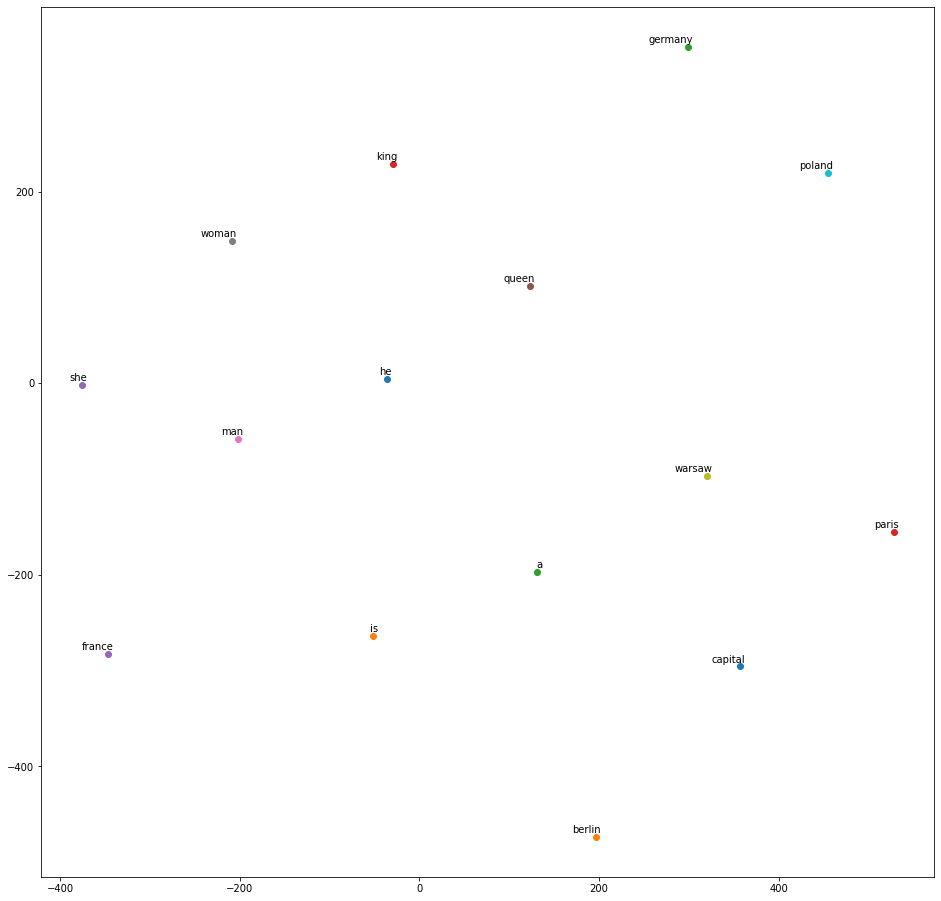

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokens = W1.detach().numpy().T
# tokens = W2.detach().numpy()
labels = [val for _, val in idx2word.items()]
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000, random_state=40)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
    xy=(x[i], y[i]),
    xytext=(5, 2),
    textcoords='offset points',
    ha='right',
    va='bottom')
plt.show()

In [21]:
idx2word

{0: 'he',
 1: 'is',
 2: 'a',
 3: 'king',
 4: 'she',
 5: 'queen',
 6: 'man',
 7: 'woman',
 8: 'warsaw',
 9: 'poland',
 10: 'capital',
 11: 'berlin',
 12: 'germany',
 13: 'paris',
 14: 'france'}

In [22]:
import GPUtil
def is_gpu_available():
    return (
        len(
            GPUtil.getAvailable(
                order="first",
                limit=1,
                maxLoad=0.5,
                maxMemory=0.5,
                includeNan=False,
                excludeID=[],
                excludeUUID=[],
            )
        )
        > 0
    )



In [23]:
is_gpu_available()

True